In [1]:
cd ../

c:\Users\elisa_nbt359l\OneDrive\Área de Trabalho\projetos\bot_teste


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from IPython.display import Image

from src.visualization import Visualization

pd.set_option('display.max_columns', None)

### Entrada de dados

Leitura dos dados, removendo características não mencionadas no texto de referência.

Correção da característica "cod_ano" para incluir dados ausentes de algumas campanhas de 2018.

Introdução de duas novas características: a porcentagem de desconto em relação ao valor do produto e o cálculo da quantidade de itens vendidos, obtido pela divisão do valor de tabela pelo preço de tabela.

In [3]:
df = pd.read_csv("dados/inputs/base_dados.csv").drop(columns = ['cod_regional_agrupador','flg_sub_acao_foco',
       'flg_sub_acao_foco_secundario', 'flg_promocao_agg', 'flg_exclusiva_fidelidade',  'vlr_preco_tabela', 'vlr_desconto_real2'])
df = df.sort_values(by='cod_ciclo', ascending=True)

In [4]:
df['cod_ano'] = df['cod_ciclo'].astype(str).str[:-2]
df['ciclo'] = df['cod_ciclo'].astype(str).str[-2:]
df['cod_agrupador_sap_material'] = df['cod_agrupador_sap_material'].astype(str).str.replace('.', '')
df['desconto_perc'] = 1 - (df['vlr_preco_venda']/df['vlr_preco_base'])
df['quant_vendida'] = round(df['vlr_rbv_tabela_so_tt']/df['vlr_preco_base'],0)

In [5]:
#Retirada de uma das campanhas
#Dados discrepantes, preço de tabela muito mais alto que os demais preços
df[df["quant_vendida"]==0]

cod_ciclo cod_ano cod_canal cod_agrupador_sap_material cod_uf  \
5873     202304    2023     Anon1            258282818934802  Anon1   

     des_categoria_material des_subcategoria_material des_marca_material  \
5873                  Anon2                     Anon4              Anon8   

     des_tier des_mecanica_consumidor des_mecanica_rev des_promocao_publico  \
5873    Anon5                   Anon3            Anon1                Anon5   

      vlr_desconto_real  vlr_rbv_tabela_so_tt  vlr_rbv_real_so_tt  \
5873                NaN                   0.0         20571.23687   

      vlr_preco_base  vlr_preco_venda ciclo  desconto_perc  quant_vendida  
5873    12522.957746        45.704225    04        0.99635            0.0

In [6]:
df = df[df["quant_vendida"]>0]

In [7]:
df.sample(3)

cod_ciclo cod_ano cod_canal cod_agrupador_sap_material cod_uf  \
17355     202208    2022     Anon2            194229790384526  Anon3   
17859     202111    2021     Anon2            224735088612281  Anon3   
6485      202307    2023     Anon2            257982046180186  Anon1   

      des_categoria_material des_subcategoria_material des_marca_material  \
17355                  Anon1                     Anon3              Anon5   
17859                  Anon1                     Anon1              Anon6   
6485                   Anon2                     Anon2              Anon8   

      des_tier des_mecanica_consumidor des_mecanica_rev des_promocao_publico  \
17355    Anon3                  Anon10            Anon1                Anon1   
17859    Anon1                   Anon3            Anon1                Anon2   
6485     Anon5                   Anon3            Anon1                Anon2   

       vlr_desconto_real  vlr_rbv_tabela_so_tt  vlr_rbv_real_so_tt  \
17355                0.0           4658.738605         4658.738605   
17859                0.0           3843.644440         3843.644440   
6485                 0.0           1871.963352         1871.963352   

       vlr_preco_base  vlr_preco_venda ciclo  desconto_perc  quant_vendida  
17355       59.084507        59.084507    08            0.0           79.0  
17859       31.619718        31.619718    11            0.0          122.0  
6485        63.309859        63.309859    07            0.0           30.0

#### Caracterização Base de Dados

In [8]:
print("Quantidade de campanhas realizadas no período: ", df.shape[0])
print("Quantidade de produtos em que foram realizadas campanhas no período: ", df['cod_agrupador_sap_material'].nunique())
print("Quantidade de marcas com campanhas realizadas no período: ",df['des_marca_material'].nunique())

Quantidade de campanhas realizadas no período:  19501
Quantidade de produtos em que foram realizadas campanhas no período:  72
Quantidade de marcas com campanhas realizadas no período:  9


### Overview

Análise dos dados ao longo dos anos revela um crescimento contínuo desde o primeiro ano, 2018, tanto em termos do número de produtos quanto do número de campanhas realizadas. O número de produtos em 2023 é mais de quatro vezes maior do que em anos anteriores.

No que diz respeito aos descontos de campanha, a média dos descontos dados em 2023 diminuiu em relação ao ano anterior e é a menor em comparação com os anos anteriores.

É importante notar que nem todos os ciclos de campanha estão presentes nos dados de 2023, sugerindo que o ano ainda não foi concluído.

In [9]:
aux = df.groupby('cod_ano')['cod_agrupador_sap_material'].nunique().reset_index()
aux['variação_percentual'] = aux['cod_agrupador_sap_material'].pct_change() * 100
aux.rename(columns = {'cod_agrupador_sap_material':'quantidade_produtos'})

cod_ano  quantidade_produtos  variação_percentual
0    2018                   13                  NaN
1    2019                   20            53.846154
2    2020                   32            60.000000
3    2021                   44            37.500000
4    2022                   66            50.000000
5    2023                   69             4.545455

In [10]:
aux = df.groupby('cod_ano')['cod_agrupador_sap_material'].count().reset_index()
aux['variação_percentual'] = aux['cod_agrupador_sap_material'].pct_change() * 100
aux.rename(columns = {'cod_agrupador_sap_material':'quantidade_campanhas'})

cod_ano  quantidade_campanhas  variação_percentual
0    2018                   501                  NaN
1    2019                  2160           331.137725
2    2020                  2599            20.324074
3    2021                  3914            50.596383
4    2022                  5531            41.313235
5    2023                  4796           -13.288736

In [11]:
aux = df.groupby('cod_ano')['vlr_rbv_real_so_tt'].sum().reset_index()
aux['variação_percentual'] = aux['vlr_rbv_real_so_tt'].pct_change() * 100
aux.rename(columns = {'vlr_rbv_real_so_tt':'receita_real'})

cod_ano  receita_real  variação_percentual
0    2018  9.941661e+06                  NaN
1    2019  3.733611e+07           275.551990
2    2020  5.909751e+07            58.285148
3    2021  9.101513e+07            54.008408
4    2022  1.100908e+08            20.958798
5    2023  8.133628e+07           -26.118923

In [12]:
#análise dos descontos médios oferecidos nas campanhas
aux = df.groupby('cod_ano')['desconto_perc'].mean().reset_index()
aux['variação_percentual'] = aux['desconto_perc'].pct_change() * 100
aux

cod_ano  desconto_perc  variação_percentual
0    2018       0.104634                  NaN
1    2019       0.082873           -20.797708
2    2020       0.086800             4.739357
3    2021       0.086913             0.129743
4    2022       0.091105             4.823088
5    2023       0.079577           -12.653232

##### Houve uma mudança de comportamento em relação a receita real e esperada ao longo do ano e dos ciclos?

A receita tem mostrado um crescimento consistente ao longo dos anos, em linha com o aumento do número de campanhas e produtos. No entanto, até 2022, não houve grandes variações nos descontos ou na diferença entre o valor real e a base.

Em 2023, observou-se uma redução nos descontos, mas é provável que mais ciclos tenham ocorrido até o fechamento do ano, o que pode influenciar essas métricas.

Considerando a existência de uma temporalidade entre os ciclos, nota-se que eles apresentam comportamentos distintos em relação à receita e aos padrões de descontos. Essa observação sugere que diferentes estratégias ou condições podem estar influenciando o desempenho financeiro e as políticas de desconto em cada ciclo específico. Investigar essas variações pode oferecer insights valiosos para otimizar futuras campanhas e maximizar os resultados.

In [13]:
Visualization.grafico_area(df, 'cod_ano', 'vlr_rbv_tabela_so_tt', 'vlr_rbv_real_so_tt', 'Receita Esperada', 'Receita Real', 'Ano', 'Valor')

In [14]:
Visualization.plot_line_chart(df, 'cod_ano', 'desconto_perc', 'Ano', 'Média de descontos')

In [15]:
Visualization.grafico_area(df, 'ciclo', 'vlr_rbv_tabela_so_tt', 'vlr_rbv_real_so_tt', 'Receita Esperada', 'Receita Real', 'Ciclo', 'Valor')

In [16]:
Visualization.plot_line_chart(df, 'ciclo', 'desconto_perc', 'Ano', 'Média de descontos')

#### Qual o grau de associação entre a quantidade vendida e o valor da receita real?

A relação entre a quantidade de itens vendidos durante a campanha e o valor da receita gerada é forte, com uma correlação de 86,9%. Portanto, durante minhas análises subsequentes, darei maior ênfase e consideração ao valor da receita como uma métrica fundamental para avaliar o desempenho das campanhas e outras variáveis associadas.

In [17]:
Visualization.grafico_dispersao(df, 'vlr_rbv_real_so_tt', 'quant_vendida', 'Receita real', 'N° de itens vendidos', ['ciclo', 'cod_ano','vlr_preco_base'])

Coeficiente de correlação: 0.8691164164776107


#### O valor da receita está associado ao valor do desconto?

A receita real não apresenta associação com o desconto oferecido. Este resultado foi crucial para o desenvolvimento da métrica de qualidade das campanhas, indicando que o desconto por si só não é um preditor confiável do sucesso financeiro de uma campanha.

In [18]:
Visualization.grafico_dispersao(df, 'vlr_rbv_real_so_tt', 'desconto_perc', 'Receita real', 'Desconto (%)', ['ciclo', 'cod_ano'])

Coeficiente de correlação: 0.16528223779462567


### Métrica de qualidade da campanha (target)

Considerando que uma campanha é considerada bem-sucedida quando gera receita sem comprometer significativamente os ganhos com descontos, optei por uma análise por quadrantes, onde foram definidos 4 grupos:

Eficiente: Campanhas com alta receita e baixo desconto. Este grupo representa campanhas que devem ser ampliadas, pois oferecem os melhores resultados para a organização.

Lucrativo: Campanhas com alta receita e alto desconto. Essas campanhas geram receita, embora os descontos oferecidos possam reduzir a lucratividade. É importante observar esse grupo, pois ajustes podem ser feitos para migrar para os grupos Eficiente ou Desafiador.

Estável: Campanhas com baixa receita e baixo desconto. Este grupo de campanhas não contribui muito para a receita, mas também não apresenta descontos elevados. A observação é importante, pois pequenos ajustes podem ser feitos para migrar as ações para os grupos Eficiente ou Desafiador.

Desafiador: Campanhas com baixa receita e alto desconto. Estas campanhas normalmente não contribuem muito para a receita e podem indicar a necessidade de reavaliação e redução, inclusive colaborando para decisões como o encerramento de produtos ou realocação da carteira.

In [19]:
df['quadrante_desconto'] = pd.cut(df['desconto_perc'], bins=[float('-inf'), df['desconto_perc'].median(), float('inf')], labels=['D-', 'D+'])
df['quadrante_receita'] = pd.cut(df['vlr_rbv_real_so_tt'], bins=[float('-inf'), df['vlr_rbv_real_so_tt'].median(), float('inf')], labels=['R-', 'R+'])

In [20]:
df['quadrante'] = df['quadrante_desconto'].astype(str) + "_" + df['quadrante_receita'].astype(str)
df['quadrante'] = df['quadrante'].replace({'D-_R-':'Estável (D-R-)','D+_R+':'Lucrativo (D+R+)','D-_R+':'Eficiente (D-R+)','D+_R-':'Desafiador (D+R-)'})

In [21]:
df.groupby('quadrante').agg({'cod_agrupador_sap_material':'nunique',
                            'cod_ciclo':'count',
                            'vlr_rbv_tabela_so_tt':'mean',
                            'vlr_rbv_real_so_tt':'mean',
                            'desconto_perc':'mean'})

cod_agrupador_sap_material  cod_ciclo  \
quadrante                                                  
Desafiador (D+R-)                          69       4313   
Eficiente (D-R+)                           69       4313   
Estável (D-R-)                             71       5438   
Lucrativo (D+R+)                           71       5437   

                   vlr_rbv_tabela_so_tt  vlr_rbv_real_so_tt  desconto_perc  
quadrante                                                                   
Desafiador (D+R-)           3272.072299         2693.098088       0.163633  
Eficiente (D-R+)           31105.016136        31051.190902       0.001940  
Estável (D-R-)              2489.689790         2485.901248       0.001061  
Lucrativo (D+R+)           53992.555146        42258.607964       0.177095

#### Inclusão de nova feature, variação do produtos em relação ao ano anterior

Para enriquecer as análises, decidi incluir uma nova feature que representa a variação da receita do produto em relação ao ano anterior. Essa métrica foi categorizada da seguinte forma: produtos novos (variação de 0%), produtos estáveis (variação entre -20% e 20%), crescimento (variação acima de 20%) e redução (variação abaixo de -20%).

Como os dados de 2023 não contemplam todos os ciclos, optei por considerar apenas os dados até o ciclo 11, seguindo uma abordagem mais simples e rápida. Além disso, excluí o ano de 2018 das demais análises, pois não há indicação da variação nesse período.

In [22]:
df[df['cod_ano']=='2023']['ciclo'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'],
      dtype=object)

In [23]:
df_ano = df[df['ciclo'].isin(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'])].groupby(['cod_agrupador_sap_material','cod_ano'])[['vlr_rbv_real_so_tt']].sum().reset_index()
df_ano = df_ano.sort_values(by=['cod_agrupador_sap_material', 'cod_ano'])
df_ano['var_perc_vlr_rbv_real_so_tt'] = (df_ano.groupby('cod_agrupador_sap_material')['vlr_rbv_real_so_tt'].pct_change() * 100).fillna(0)

In [24]:
df = df.merge(df_ano[['cod_ano','cod_agrupador_sap_material','var_perc_vlr_rbv_real_so_tt']], on = ['cod_ano','cod_agrupador_sap_material'])
df['variacao_ano'] = pd.cut(df['var_perc_vlr_rbv_real_so_tt'], bins=[-float('inf'), -20,-0.00000001, 0.00000001,20, float('inf')], labels=['Redução', 'Estabilidade', 'Novo', 'Estabilidade', 'Aumento'], 
                             ordered=False)
df = df[df['cod_ano']>'2018']

## Quais fatores estão associados ao resultado das campanhas?

Para abordar a pergunta central, decidi ajustar uma árvore de decisão com o propósito exploratório de identificar quais fatores são importantes para classificar as campanhas nos grupos de resultados criados pelo indicador alvo.

A árvore de decisão é um modelo de aprendizado de máquina que divide os dados em subconjuntos menores com base nas características dos dados, ajudando a identificar padrões e relações entre as variáveis. 

In [25]:
categorical_cols = ['ciclo', 'cod_canal','cod_uf', 'des_categoria_material', 'des_subcategoria_material', 'des_marca_material', 'des_promocao_publico', 'des_tier','variacao_ano']  
encoder = OneHotEncoder()
X = encoder.fit_transform(df[categorical_cols])
model = DecisionTreeClassifier(max_depth= 10, max_leaf_nodes=15, min_samples_split=20 , random_state=42)
model.fit(X, df['quadrante'])

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=15, min_samples_split=20,
                       random_state=42)

In [26]:
y_pred = model.predict(X)

accuracy = accuracy_score(df['quadrante'], y_pred)
precision = precision_score(df['quadrante'], y_pred, average='weighted')
recall = recall_score(df['quadrante'], y_pred, average='weighted')
f1 = f1_score(df['quadrante'], y_pred, average='weighted')
conf_matrix = confusion_matrix(df['quadrante'], y_pred)

print("Acurácia: {:.2f}".format(accuracy))
print("Precisão: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))
print("\nMatriz de Confusão:")
print(conf_matrix)

Acurácia: 0.55
Precisão: 0.58
Recall: 0.55
F1-score: 0.54

Matriz de Confusão:
[[1595   32  784 1641]
 [ 174 1433  811 1674]
 [ 602  590 3123  969]
 [ 626   59  244 3947]]


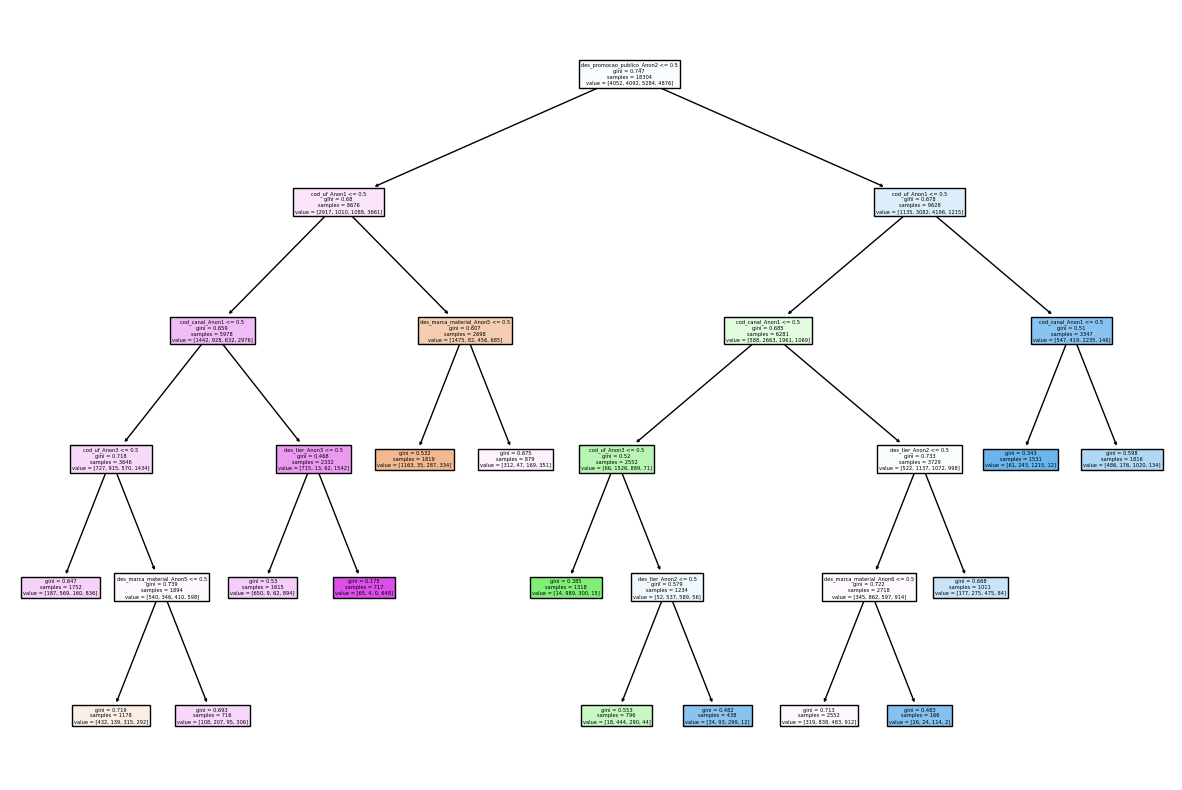

In [27]:
#árvore de decisão
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=list(encoder.get_feature_names_out(categorical_cols)), filled=True)
plt.show()

In [28]:
# Features mais importantes para a classificação
importance = model.feature_importances_
encoded_feature_names = list(encoder.get_feature_names_out(categorical_cols)) 
df_importance = pd.DataFrame({'Feature': encoded_feature_names, 'Importance': importance})
df_importance = df_importance[df_importance["Importance"]>0].sort_values(by='Importance', ascending=True)

In [29]:
fig = px.bar(df_importance, x='Importance', y='Feature', orientation='h',
             title='Features mais importantes para a classificação')
fig.show()

#### Análise de correspondência


Para visualizar a relação entre as características e os grupos de resultado das campanhas, optei por realizar uma análise de correspondência. Assim como a análise de componentes principais, a análise de correspondência reescreve a variabilidade dos dados em componentes. As duas primeiras componentes principais capturam a maior parte da variabilidade dos dados, representando quase 99% dela. Essas duas componentes foram utilizadas para relacionar as características em um plano bidimensional.

A análise e o gráfico foram realizados usando o R. 

Observa-se uma associação entre a marca_6, UF_1 e Preço_2 com receitas menores. O Canal_2 e o Público_2 estão associados a descontos maiores, enquanto a marca_5 e a UF_2 estão relacionadas a receitas maiores. Essas observações indicam padrões de comportamento que podem ser explorados para entender melhor as dinâmicas de mercado e orientar estratégias futuras.

In [30]:
colunas = ['quadrante','cod_canal','cod_uf','des_tier', 'des_promocao_publico', 'des_marca_material']
df_analise_correp = df[colunas]

In [31]:
rename_canal = {'Anon1':'Canal_1','Anon2':'Canal_2'}
rename_uf = {'Anon1':'UF_1','Anon2':'UF_2','Anon3':'UF_3'}
rename_preco = {'Anon1':'Preço_Outros','Anon2':'Preço_2','Anon3':'Preço_Outros','Anon4':'Preço_Outros','Anon5':'Preço_Outros','Anon6':'Preço_Outros'}
rename_publico = {'Anon1':'Público_Outros','Anon2':'Público_2','Anon3':'Público_Outros','Anon4':'Público_Outros','Anon5':'Público_Outros'}
rename_marca = {'Anon1':'Marca_Outras','Anon2':'Marca_Outras','Anon3':'Marca_Outras','Anon4':'Marca_Outras','Anon5':'Marca_5','Anon6':'Marca_6',
                'Anon7':'Marca_Outras','Anon8':'Marca_Outras','Anon9':'Marca_Outras'}

df_analise_correp['cod_canal'] = df_analise_correp['cod_canal'].replace(rename_canal)
df_analise_correp['cod_uf'] = df_analise_correp['cod_uf'].replace(rename_uf)
df_analise_correp['des_tier'] = df_analise_correp['des_tier'].replace(rename_preco)
df_analise_correp['des_promocao_publico'] = df_analise_correp['des_promocao_publico'].replace(rename_publico)
df_analise_correp['des_marca_material'] = df_analise_correp['des_marca_material'].replace(rename_marca)

C:\Users\elisa_nbt359l\AppData\Local\Temp\ipykernel_11208\2692172955.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\elisa_nbt359l\AppData\Local\Temp\ipykernel_11208\2692172955.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\elisa_nbt359l\AppData\Local\Temp\ipykernel_11208\2692172955.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [32]:
aux = df_analise_correp[['quadrante',colunas[1]]].rename(columns = {colunas[1]:'caracteristica'})
for var in colunas[2:]:
    aux = pd.concat([aux, df_analise_correp[['quadrante',var]].rename(columns = {var:'caracteristica'})], axis=0)
    #aux.to_csv("dados_analise_correspondencia_2.csv")

In [33]:
#gráfico de dispersão das duas primeiras componentes
Image(url='https://raw.githubusercontent.com/elisacastro90/case_bot/master/dados/outputs/resultado_analise_correspondencia.png')

### Análise dos resultados

In [34]:
#filtrando o ano mais recente
df_filtro = df[df['cod_ano']=='2023']

##### Quais produtos pertencem aos grupos formados

In [35]:
aux_1 = pd.crosstab(df_filtro['cod_agrupador_sap_material'], df_filtro['quadrante'], normalize='index').reset_index()
aux_2 = df_filtro['cod_agrupador_sap_material'].value_counts().reset_index().rename(columns = {'count':'N° de ações'})
df_produto = aux_1.merge(aux_2, on = ['cod_agrupador_sap_material'])

In [36]:
for var in df_produto.columns[1:5]:
    print("Produtos com mais de 50% de itens do grupo " + var)
    display(df_produto[df_produto['Desafiador (D+R-)']>0.5])

Produtos com mais de 50% de itens do grupo Desafiador (D+R-)


cod_agrupador_sap_material  Desafiador (D+R-)  Eficiente (D-R+)  \
5             153903104900282           0.603774          0.037736   
7              15685299153209           0.768116          0.000000   
8             156991809726528           0.643836          0.000000   
9             157003377909398           0.520833          0.000000   
16             17159085650826           0.581081          0.013514   
17            187392994308454           0.692308          0.000000   
38             23457961223451           0.563380          0.000000   

    Estável (D-R-)  Lucrativo (D+R+)  N° de ações  
5         0.358491          0.000000           53  
7         0.231884          0.000000           69  
8         0.356164          0.000000           73  
9         0.479167          0.000000           48  
16        0.364865          0.040541           74  
17        0.307692          0.000000           65  
38        0.422535          0.014085           71

Produtos com mais de 50% de itens do grupo Eficiente (D-R+)


cod_agrupador_sap_material  Desafiador (D+R-)  Eficiente (D-R+)  \
5             153903104900282           0.603774          0.037736   
7              15685299153209           0.768116          0.000000   
8             156991809726528           0.643836          0.000000   
9             157003377909398           0.520833          0.000000   
16             17159085650826           0.581081          0.013514   
17            187392994308454           0.692308          0.000000   
38             23457961223451           0.563380          0.000000   

    Estável (D-R-)  Lucrativo (D+R+)  N° de ações  
5         0.358491          0.000000           53  
7         0.231884          0.000000           69  
8         0.356164          0.000000           73  
9         0.479167          0.000000           48  
16        0.364865          0.040541           74  
17        0.307692          0.000000           65  
38        0.422535          0.014085           71

Produtos com mais de 50% de itens do grupo Estável (D-R-)


cod_agrupador_sap_material  Desafiador (D+R-)  Eficiente (D-R+)  \
5             153903104900282           0.603774          0.037736   
7              15685299153209           0.768116          0.000000   
8             156991809726528           0.643836          0.000000   
9             157003377909398           0.520833          0.000000   
16             17159085650826           0.581081          0.013514   
17            187392994308454           0.692308          0.000000   
38             23457961223451           0.563380          0.000000   

    Estável (D-R-)  Lucrativo (D+R+)  N° de ações  
5         0.358491          0.000000           53  
7         0.231884          0.000000           69  
8         0.356164          0.000000           73  
9         0.479167          0.000000           48  
16        0.364865          0.040541           74  
17        0.307692          0.000000           65  
38        0.422535          0.014085           71

Produtos com mais de 50% de itens do grupo Lucrativo (D+R+)


cod_agrupador_sap_material  Desafiador (D+R-)  Eficiente (D-R+)  \
5             153903104900282           0.603774          0.037736   
7              15685299153209           0.768116          0.000000   
8             156991809726528           0.643836          0.000000   
9             157003377909398           0.520833          0.000000   
16             17159085650826           0.581081          0.013514   
17            187392994308454           0.692308          0.000000   
38             23457961223451           0.563380          0.000000   

    Estável (D-R-)  Lucrativo (D+R+)  N° de ações  
5         0.358491          0.000000           53  
7         0.231884          0.000000           69  
8         0.356164          0.000000           73  
9         0.479167          0.000000           48  
16        0.364865          0.040541           74  
17        0.307692          0.000000           65  
38        0.422535          0.014085           71

##### Quais caracteristicas são presentes nos grupos formados

In [37]:
for var in colunas[1:]:
    display(pd.crosstab(df_filtro[var], df_filtro['quadrante'], normalize='index'))

quadrante  Desafiador (D+R-)  Eficiente (D-R+)  Estável (D-R-)  \
cod_canal                                                        
Anon1               0.280679          0.175372        0.281953   
Anon2               0.215895          0.286358        0.343302   

quadrante  Lucrativo (D+R+)  
cod_canal                    
Anon1              0.261996  
Anon2              0.154445

quadrante  Desafiador (D+R-)  Eficiente (D-R+)  Estável (D-R-)  \
cod_uf                                                           
Anon1               0.323342          0.088010        0.469388   
Anon2               0.165115          0.385475        0.162011   
Anon3               0.256648          0.218306        0.312307   

quadrante  Lucrativo (D+R+)  
cod_uf                       
Anon1              0.119260  
Anon2              0.287399  
Anon3              0.212740

quadrante  Desafiador (D+R-)  Eficiente (D-R+)  Estável (D-R-)  \
des_tier                                                         
Anon1               0.379102          0.093264        0.438687   
Anon2               0.413655          0.070950        0.463186   
Anon3               0.154671          0.338847        0.244077   
Anon4               0.430556          0.069444        0.458333   
Anon5               0.108247          0.323024        0.118557   

quadrante  Lucrativo (D+R+)  
des_tier                     
Anon1              0.088946  
Anon2              0.052209  
Anon3              0.262405  
Anon4              0.041667  
Anon5              0.450172

quadrante             Desafiador (D+R-)  Eficiente (D-R+)  Estável (D-R-)  \
des_promocao_publico                                                        
Anon1                          0.317877          0.181818        0.167175   
Anon2                          0.135840          0.295238        0.477193   
Anon3                          0.287109          0.217773        0.265625   
Anon4                          0.739130          0.014493        0.028986   

quadrante             Lucrativo (D+R+)  
des_promocao_publico                    
Anon1                         0.333130  
Anon2                         0.091729  
Anon3                         0.229492  
Anon4                         0.217391

quadrante           Desafiador (D+R-)  Eficiente (D-R+)  Estável (D-R-)  \
des_marca_material                                                        
Anon1                        0.391003          0.077278        0.444060   
Anon2                        0.468333          0.040000        0.441667   
Anon3                        0.190476          0.197279        0.551020   
Anon4                        0.191781          0.301370        0.315068   
Anon5                        0.154671          0.338847        0.244077   
Anon6                        0.394495          0.087156        0.458716   
Anon7                        0.430556          0.069444        0.458333   
Anon8                        0.108247          0.323024        0.118557   

quadrante           Lucrativo (D+R+)  
des_marca_material                    
Anon1                       0.087659  
Anon2                       0.050000  
Anon3                       0.061224  
Anon4                       0.191781  
Anon5                       0.262405  
Anon6                       0.059633  
Anon7                       0.041667  
Anon8                       0.450172

### Próximos Passos

**Avaliação da Influência dos Fatores:** Utilizar métodos como Shapley e Line para explicabilidade local e compreender como cada variável contribui para a classificação das campanhas em grupos específicos.

**Análise dos Erros de Classificação:** Investigar instâncias de classificação incorreta para identificar padrões e entender quais características podem ter contribuído para esses erros, fornecendo insights valiosos sobre as limitações do modelo.

**Acompanhamento da Migração entre Grupos:** Monitorar o movimento das campanhas ao longo do tempo para analisar se há uma tendência de migração entre os grupos criados e entender como as estratégias de marketing e outras variáveis estão influenciando o desempenho das campanhas.

### Oportunidades

**Inclusão do Custo da Campanha e do Custo do Item:** Incorporar o custo da campanha e o custo do item nas análises para avaliar o retorno sobre o investimento (ROI) e entender como esses custos impactam o sucesso das campanhas.

**Desenvolvimento de um Modelo para Estimar o Sucesso da Campanha:** Construir um modelo preditivo que utilize variáveis como características da campanha, custo, tipo de produto, entre outros, para estimar o sucesso da campanha e prever seu desempenho futuro.

**Desenvolvimento de Metodologia para Identificar Produtos com Queda no Sucesso das Campanhas Realizadas:** Criar uma metodologia analítica que detecte padrões de queda no sucesso das campanhas para produtos específicos ao longo do tempo, identificando fatores ou tendências que contribuem para essa redução de sucesso e sugerindo ações corretivas.